# preprocess plates and recognize the characters

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from normalize_utils import normalize_char

def visualize_plate_processing(plate_roi, template_dict=None):
    # --- Step 1: Convert to grayscale ---
    gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)

    # --- Step 2: CLAHE ---
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # gray_clahe = clahe.apply(gray)

    # --- Step 3: Top-hat enhancement ---
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,3))
    # tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    # gray_enhanced = cv2.add(gray, tophat)

    # --- Step 4: Sharpen ---
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    alpha = 1.2
    sharpened = cv2.addWeighted(gray, 1 + alpha, blurred, -alpha, 0)
    sharpened = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)

    # --- Step 5: Threshold ---
    thresh = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 17, 5)

    # --- Step 6: Morphological closing ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # --- Step 7: Projection profile ---
    projection = np.sum(morph, axis=0)
    mean_proj = np.mean(projection)

    # --- Step 8: Valley detection for character splits ---
    valleys = np.where(projection < mean_proj * 0.6)[0]
    splits = []
    if len(valleys) > 0:
        group = [valleys[0]]
        for i in range(1, len(valleys)):
            if valleys[i] - valleys[i - 1] > 2:
                splits.append(int(np.mean(group)))
                group = [valleys[i]]
            else:
                group.append(valleys[i])
        splits.append(int(np.mean(group)))

    # --- Step 9: Character segmentation ---
    flat_threshold = 0.08 * np.max(projection)
    min_valid_start = np.argmax(projection > flat_threshold)
    skip_start = max(min_valid_start - 3, 0)

    chars = []
    prev = skip_start
    for s in splits:
        if s <= skip_start:
            continue
        seg = morph[:, prev:s]
        if seg.shape[1] > 5:
            chars.append(seg)
        prev = s
    seg = morph[:, prev:]
    if seg.shape[1] > 5:
        chars.append(seg)

    # --- Visualization setup ---
    fig, axs = plt.subplots(3, 3, figsize=(14, 10))
    axs = axs.ravel()

    axs[0].imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Plate")

    # axs[1].imshow(gray_clahe, cmap='gray')
    # axs[1].set_title("CLAHE Enhanced")

    # axs[2].imshow(gray_enhanced, cmap='gray')
    # axs[2].set_title("Tophat Enhanced")

    axs[3].imshow(sharpened, cmap='gray')
    axs[3].set_title("Sharpened")

    axs[4].imshow(thresh, cmap='gray')
    axs[4].set_title("Adaptive Threshold")

    axs[5].imshow(morph, cmap='gray')
    axs[5].set_title("Morph Close (Binary Mask)")

    # --- Projection plot ---
    axs[6].plot(projection)
    axs[6].set_title("Horizontal Projection Profile")
    axs[6].axhline(mean_proj, color='r', linestyle='--', label='Mean')
    axs[6].legend()

    # --- Projection overlaid on image ---
    proj_overlay = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    for s in splits:
        cv2.line(proj_overlay, (s, 0), (s, morph.shape[0]), (0, 255, 0), 1)
    axs[7].imshow(proj_overlay)
    axs[7].set_title("Splits on Plate")

    # --- Character segments preview ---
    combined_chars = np.concatenate([cv2.copyMakeBorder(ch, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=255)
                                     for ch in chars], axis=1) if chars else np.zeros_like(morph)
    axs[8].imshow(combined_chars, cmap='gray')
    axs[8].set_title(f"Detected Characters ({len(chars)})")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # --- Return segmented characters if you want to process OCR next ---
    return chars


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from normalize_utils import normalize_char

def visualize_plate_with_matching(plate_roi, template_dict):
    # --- Step 1: Convert to grayscale ---
    gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)

    # # --- Step 2: CLAHE ---
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray)

    # # --- Step 3: Top-hat enhancement ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,3))
    tophat = cv2.morphologyEx(gray_clahe, cv2.MORPH_TOPHAT, kernel)
    gray_enhanced = cv2.add(gray_clahe, tophat)

    # --- Step 4: Sharpen ---
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    alpha = 1.3
    sharpened = cv2.addWeighted(gray, 1 + alpha, blurred, -alpha, 0)
    sharpened = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)

    # --- Step 5: Threshold ---
    thresh = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 17, 5)

    # --- Step 6: Morphological closing ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # --- Step 7: Projection profile ---
    projection = np.sum(morph, axis=0)
    mean_proj = np.mean(projection)

    valleys = np.where(projection < mean_proj * 0.6)[0]
    splits = []
    if len(valleys) > 0:
        group = [valleys[0]]
        for i in range(1, len(valleys)):
            if valleys[i] - valleys[i - 1] > 4:
                splits.append(int(np.mean(group)))
                group = [valleys[i]]
            else:
                group.append(valleys[i])
        splits.append(int(np.mean(group)))

    # --- Step 8: Character segmentation ---
    flat_threshold = 0.08 * np.max(projection)
    min_valid_start = np.argmax(projection > flat_threshold)
    skip_start = max(min_valid_start - 3, 0)

    chars = []
    prev = skip_start
    for s in splits:
        if s <= skip_start:
            continue
        seg = morph[:, prev:s]
        if seg.shape[1] > 5:
            chars.append(seg)
        prev = s
    seg = morph[:, prev:]
    if seg.shape[1] > 5:
        chars.append(seg)

    if len(chars) > 1:
        widths = [ch.shape[1] for ch in chars]
        if widths[0] < 0.3 * np.mean(widths) or widths[0] < 10:
            chars = chars[1:]

    num_chars = len(chars)
    if num_chars < 4 or num_chars > 8:
        print("⚠️ Skipping plate: invalid char count")
        return None

    # --- Step 9: Template matching and visualization ---
    plate_text = ""
    match_results = []

    for idx, ch in enumerate(chars):
        if ch.shape[0] < 10 or ch.shape[1] < 5:
            continue

        ch_norm = normalize_char(ch, (50, 60))
        _, ch_norm = cv2.threshold(ch_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(ch_norm) > 127:
            ch_norm = 255 - ch_norm

        best_score, best_match, best_tmpl = -1, None, None
        group_type = "letters" if idx < 2 else "digits"

        for name, tmpl_list in template_dict[group_type].items():
            for tmpl in tmpl_list:
                tmpl_norm = normalize_char(tmpl, (50, 60))
                res = cv2.matchTemplate(ch_norm, tmpl_norm, cv2.TM_CCOEFF_NORMED)
                _, score, _, _ = cv2.minMaxLoc(res)
                if score > best_score:
                    best_score, best_match, best_tmpl = score, name, tmpl_norm

        if best_score > 0.2 and best_match:
            plate_text += best_match
            match_results.append((ch_norm, best_tmpl, best_match, best_score))
        else:
            match_results.append((ch_norm, None, '?', 0.0))

    # --- Step 10: Plot all stages ---
    fig, axs = plt.subplots(3, 3, figsize=(14, 10))
    axs = axs.ravel()

    axs[0].imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Plate")

    axs[1].imshow(gray_clahe, cmap='gray'); axs[1].set_title("CLAHE Enhanced")
    axs[2].imshow(gray_enhanced, cmap='gray'); axs[2].set_title("Tophat Enhanced")
    axs[3].imshow(sharpened, cmap='gray'); axs[3].set_title("Sharpened")
    axs[4].imshow(thresh, cmap='gray'); axs[4].set_title("Adaptive Threshold")
    axs[4].imshow(morph, cmap='gray'); axs[5].set_title("Morph Close")

    axs[5].plot(projection); axs[6].axhline(mean_proj, color='r', ls='--', label='Mean')
    axs[5].set_title("Projection Profile"); axs[6].legend()

    proj_overlay = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    for s in splits:
        cv2.line(proj_overlay, (s, 0), (s, morph.shape[0]), (0, 255, 0), 1)
    axs[6].imshow(proj_overlay); axs[7].set_title("Splits on Plate")

    combined_chars = np.concatenate([cv2.copyMakeBorder(ch, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=255)
                                     for ch in chars], axis=1) if chars else np.zeros_like(morph)
    axs[7].imshow(combined_chars, cmap='gray')
    axs[8].set_title(f"Detected Characters ({len(chars)})")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Step 11: Display template matches per character ---
    if match_results:
        fig, axs = plt.subplots(len(match_results), 2, figsize=(6, 3*len(match_results)))
        if len(match_results) == 1:
            axs = [axs]
        for i, (char_img, tmpl, name, score) in enumerate(match_results):
            axs[i][0].imshow(char_img, cmap='gray')
            axs[i][0].set_title(f"Char {i+1}: Pred {name}\nScore {score:.2f}")
            axs[i][0].axis('off')

            if tmpl is not None:
                axs[i][1].imshow(tmpl, cmap='gray')
                axs[i][1].set_title(f"Matched Template: {name}")
            else:
                axs[i][1].imshow(np.zeros_like(char_img), cmap='gray')
                axs[i][1].set_title("No match")
            axs[i][1].axis('off')

        plt.tight_layout()
        plt.show()

    print(f"✅ Final Recognized Plate: {plate_text}")
    return plate_text


In [32]:
import os
import cv2
from collections import defaultdict

def load_templates(template_folder):
    template_dict = {
        "letters": defaultdict(list),
        "digits": defaultdict(list)
    }

    for fname in sorted(os.listdir(template_folder)):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(template_folder, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Extract character from filename prefix (e.g., 'A_1.png' -> 'A')
        char_label = fname.split('_')[0].upper()

        # Categorize into letters or digits
        if char_label.isalpha():
            template_dict["letters"][char_label].append(img)
        elif char_label.isdigit():
            template_dict["digits"][char_label].append(img)

    print(f"✅ Loaded {sum(len(v) for v in template_dict['letters'].values())} letter templates "
          f"and {sum(len(v) for v in template_dict['digits'].values())} digit templates.")
    return template_dict


✅ Loaded 155 letter templates and 61 digit templates.


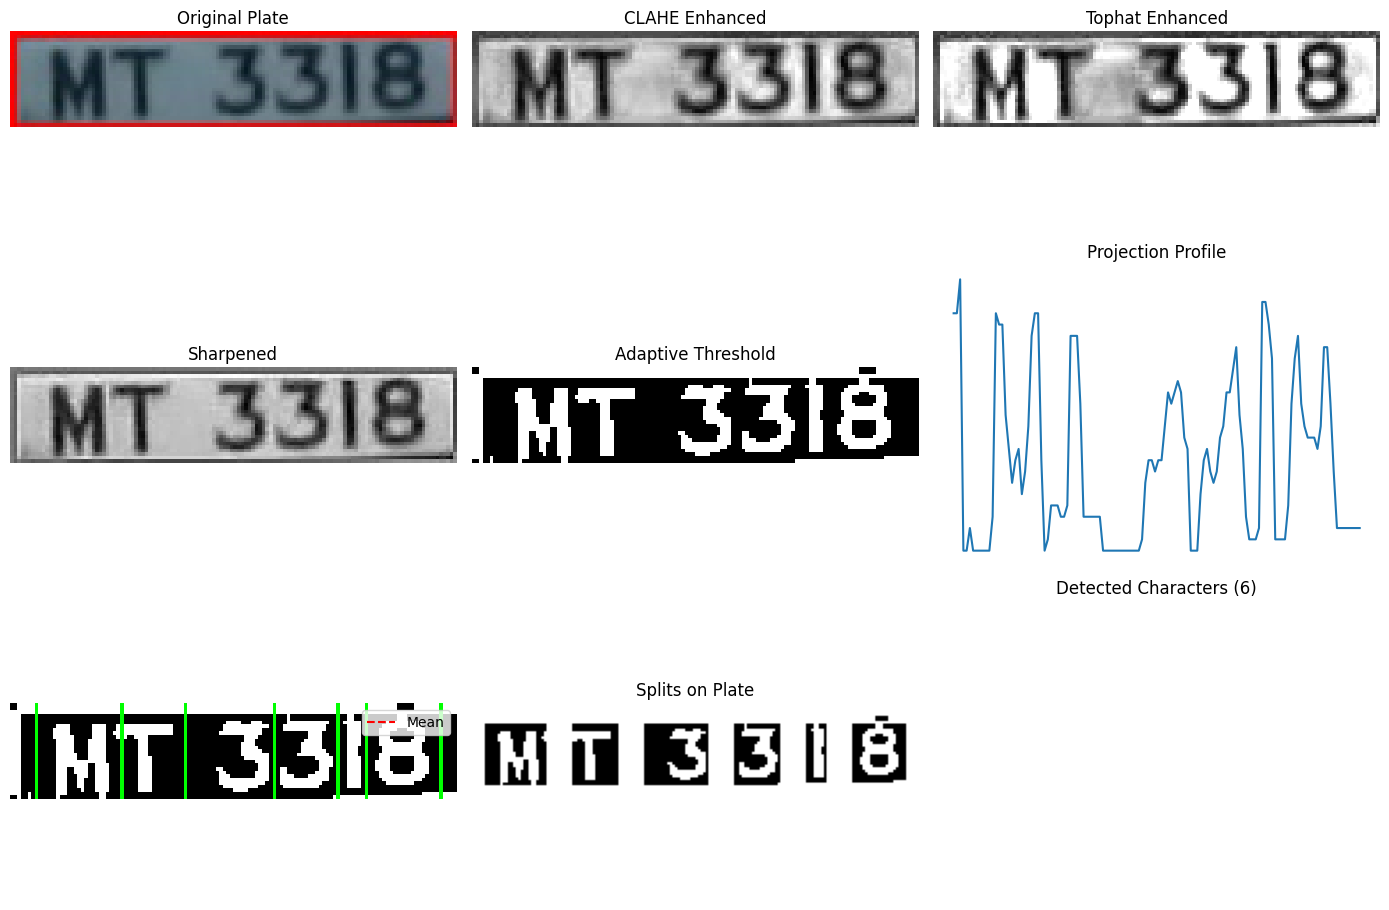

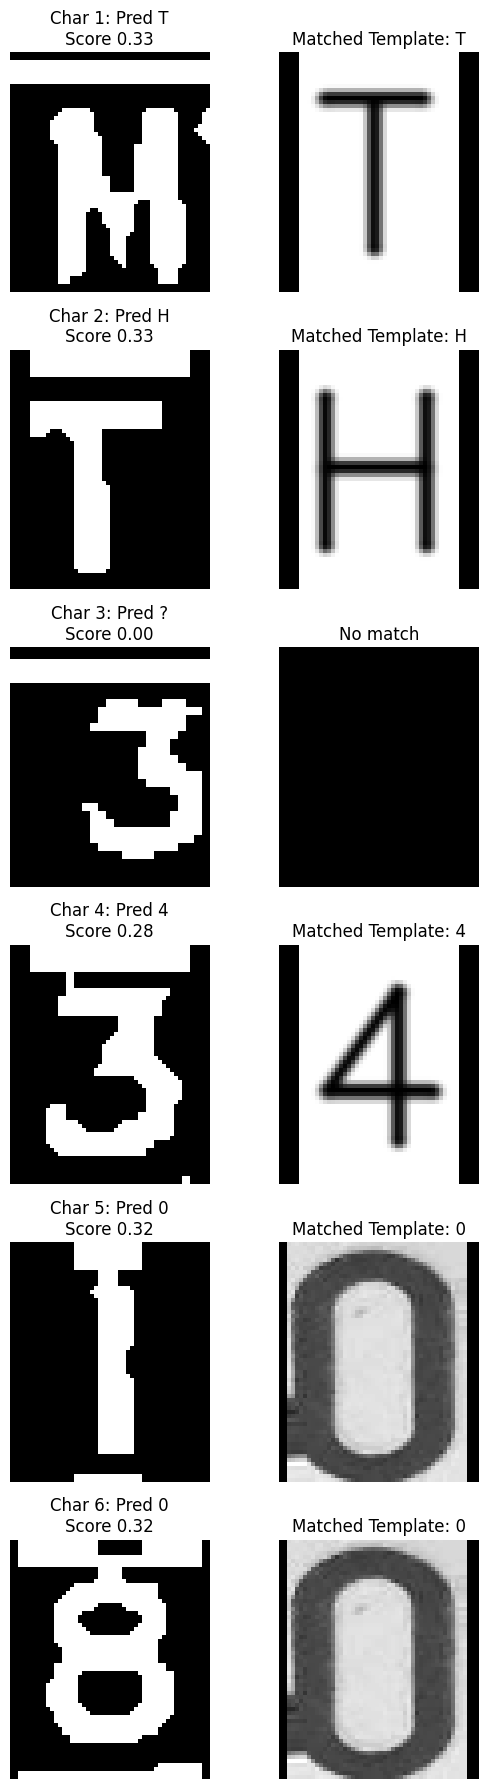

✅ Final Recognized Plate: TH400


'TH400'

In [33]:
# Example usage



template_path = "/Users/ilakkiat/Documents/MIT/SEM-V/CV-LAB/CV-PROJECT/CODE/templates/char_templates_hybrid"
template_dict = load_templates(template_path)

# Then call your visualization function
plate_img = cv2.imread("/Users/ilakkiat/Documents/MIT/SEM-V/CV-LAB/CV-PROJECT/CODES/preprocessing/output_plates/plate_48_6_6.jpg")
visualize_plate_with_matching(plate_img, template_dict)
